## <center>Sales Opportunity Scoring</center>

## <center>Submitted By</center>

## <center>Ben Karabinus</center>

## <center>University of Denver</center>

## <center> Ritchie School of Engineering and Computer Science</center>

## <center>COMP 4447, Data Science Tools 1</center>

## <center>Spring Quarter 2022</center>


The Jupyter Notebook used to conduct this analysis is hosted in the following GitHub Repositiory: __[TOOL1_FINAL_PROJECT](https://github.com/bkarabin1290/TOOL1_FINAL_PROJECT)__

## _Opportunity Scoring Motivation_

A sales opportunity can be defined as a sales account that has been qualified as showing legitimate interest in purchasing a product or service from another business entity. Businesses with sales departments commonly track opportunities through software using a customer relationship management system (CRM). CRM applications store attributes related to opportunities in an organization's sales pipeline. Attributes regarding a given opportunity may include what products or services are potentially being purchased, details of any existing relationship with the individual or company listed on an opportunity record, or which sales representative owns a given opportunity. Sales teams use this information to determine which pursuits have the greatest likelihood of success and therefore should be pursued more aggressively. Many organizations use this data to create dashboards displaying key performance metrics like sales leaders for the current fiscal year, expected revenue in the sales pipeline, or win percentage. These measures are useful in understanding how a sales department is operating from a high-level, but they fail to provide a quantifiable method of predicting whether a given sales opportunity will result in a win or loss. Past observations of won/lost opportunities should be used to create an analytical model for predicting the outcome of opportunities currently in an organization’s sales pipeline.

In [45]:
"""
Import necessary libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from optuna.integration import LightGBMPruningCallback


## *Sales Opportunity Data*

The dataset used for this project was exported from Dynamics CRM, a cloud-hosted customer relationship management system powered by Microsoft Dataverse (formerly Common Data Service). Records describe opportunities created by sales professionals that work for a consulting firm specializing in the implementation and management of business applications. Sales pursuits range from full scale Enterprise Resource Planning (ERP) software implementations costing millions of dollars to short-term agreements for providing consulting services.

Data was exported from Dynamics CRM as an Excel workbook with the initial record set consisting of 3894 records including over 100 features for each sales opportunity. This was then reduced to 66 relevant features by consulting stakeholders working for the organization where the data was sourced. Following this reduction, the dataset was converted to a binary format (pickle file) to preserve proper data types when read into Pandas Dataframes for further analysis. Records include attributes obtained using the North American Industry Classification Service __[(NAICS)](https://www.census.gov/naics/)__. To obtain further information regarding NAICS attributes listed on opportunity records, an Excel export was taken from a separate NAICS data store and merged with the primary dataset. 

Due to the large number of features included in the initial export a description of each field will be given following feature selection.

In [2]:
"""
Read in the data
"""
opportunities = pd.read_pickle('opportunities.p')
NAICS = pd.read_pickle('NAICS.p')

### *Data Cleaning and Feature Engineering*

 Objectives
- Column naming convention
- NAICS categories must be joined with opportunities.
- Record creation date should be subtracted from system close date to create a new feature representing days an opportunity is active.
- The range of estimated revenue for opportunities varies greatly. A feature categorizing estimated revenue by quartile range should be added.
- Remove non-informative or irrelevant data.
- Handle missing data.
- Separate categorical and continuous features for further analysis.

In [3]:
""" print dataframe summary"""
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 66 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   (Do Not Modify) Opportunity                                  3894 non-null   object        
 1   Entity ID (Account) (Account)                                3863 non-null   float64       
 2   Address 1: City (Account) (Account)                          3884 non-null   object        
 3   Address 1: State/Province (Account) (Account)                3880 non-null   object        
 4   Address 1: County (Account) (Account)                        3676 non-null   object        
 5   Address 1: Country/Region (Account) (Account)                3884 non-null   object        
 6   Address 1: ZIP/Postal Code (Account) (Account)               3881 non-null   object        
 7   Address 1: Lati

*Rename columns for ease of use and readability*

In [4]:
"""use combination of regular expressions to remove system generated characters from feature names"""
opportunities.columns = opportunities.columns.str.replace('\([^)]*\)', '', regex=True)
opportunities.columns = opportunities.columns.str.replace('\.', '', regex=True)
opportunities.columns = opportunities.columns.str.replace(':', '')
opportunities.columns = opportunities.columns.str.replace('/', '_')
opportunities = opportunities.rename(columns=lambda x : x.strip())
opportunities.columns = opportunities.columns.str.replace(' ','_')
opportunities.columns = opportunities.columns.str.replace('Address_1', '')
opportunities.columns = opportunities.columns.str.replace('^_', '', regex=True)
opportunities = opportunities.rename(columns=lambda x : x.strip())

In [5]:
"""
rename system system generated GUID as opportunityID
rename binary target variable "Status" as "Won"
"""
opportunities.rename(columns={opportunities.columns[0]: 'opportunity_id', 'Status' : 'Won'},
                     inplace=True)

In [6]:
"""prepare NAICS codes for join"""
# extract numeric NAICS codes from NAICS column of opportunities dataframe
opportunities['NAICS'] = opportunities['NAICS'].str.replace(r'\D', '', regex=True)
opportunities['NAICS'] = opportunities['NAICS'].str.strip()
opportunities['NAICS'] = opportunities['NAICS'].fillna(value=0)
opportunities['NAICS'] = opportunities['NAICS'].astype(int)

In [7]:
"""merge opportunities and NAICS dataframes on extracted NAICS codes"""
opportunities = pd.merge(opportunities, NAICS, how='inner', left_on = ['NAICS'],  right_on = ['mcg_naicscode'])

*Handle Missing and Non-informative Data*

- Drop columns containing non-informative data or irrelevant data
- Replace missing values for categorical features with "\_missing_"
- Drop categorical features that take on single value
- Replace missing numerical features with appropriate values or drop if necessary

In [8]:
"""drop additional columns brought in when merging opportunities and NAICS dataframes"""
opportunities.drop(columns=['mcg_naicscode','mcg_name', 'mcg_sicdescription',
                            'NAICS', 'mcg_description', 'mcg_subsectortext0'], 
                            axis=1, inplace=True)

In [9]:
"""rename NAICS columns that were joined on the opportunities dataframe"""
opportunities.rename(columns={'mcg_industry_displayname' : 'industry','mcg_industrysector_displayname' : 'industry_sector'}, 
                     inplace=True)

In [10]:
"""verify data type for datetime columns"""
print(opportunities['Created_On'].dtype)
print(opportunities['Est_Close_Date'].dtype)
print(opportunities['System_Close_Date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [11]:
"""create new feature days active"""
opportunities['days_active'] = opportunities['System_Close_Date'] - opportunities['Created_On']
opportunities['days_active'] = opportunities['days_active'] / np.timedelta64(1, 'D')
opportunities['days_active'][opportunities['days_active'] <= 0].count()

858

Creating the new feature "days_active" shows the existence of 858 opportunities that were active for a negative number of days. This is due to errors with data entry. For this analysis all sales opportunities with negative days_active will be removed from the data.

In [12]:
"""drop problem dates"""
problem_dates = \
opportunities[['days_active', 'Created_On', 'System_Close_Date']][opportunities['days_active'] < 0].index
opportunities.drop(index=problem_dates, inplace=True)

In [13]:
"""create a new feature "revenue_size" as categorical representation of estimated revenue for a given opportunity"""
# get quartile range using pd.describe() function
revenue_range = opportunities['Est_Revenue'].describe()
# bin data by quartile range, category levels low, med, high
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['min'], revenue_range['25%'], 'both'),
                                                       'revenue_size'] = 'low'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['25%'], revenue_range['75%'], 'right'),
                                                       'revenue_size'] = 'med'
opportunities.loc[opportunities['Est_Revenue'].between(revenue_range['75%'], revenue_range['max'], 'right'),
                                                       'revenue_size'] = 'high'

Separate continuous and categorical features

In [14]:
"""ensure no missing values in key columns"""
opportunities[['opportunity_id', 'Entity_ID']].isna().sum()

opportunity_id    0
Entity_ID         0
dtype: int64

In [15]:
"""separate numerical, categorical, and geographic features"""
opportunityID = opportunities[['opportunity_id', 'Entity_ID']].copy()
# select numeric feature vectors
opp_numeric = opportunities.select_dtypes(include=[np.number])
# select discrete feature vectors
opp_non_numeric = opportunities.select_dtypes(exclude=[np.number])
opp_non_numeric.drop(columns=['City', 'State_Province', 'Country_Region','County',
                             'ZIP_Postal_Code'], inplace=True)
# select geographic feature vectors
opp_geographic = opportunities.iloc[:, 0:9].copy()

In [16]:
"""reset indices to unique combination of opportunity_id and Entity_ID"""
# join key columns to data
opp_numeric = pd.merge(opportunityID, opp_numeric, left_index=True, right_index=True, how='inner')
opp_non_numeric = pd.merge(opportunityID, opp_non_numeric, left_index=True, right_index=True, how='inner')
# drop resulting duplicates and unused columns
opp_numeric.drop(columns=['Entity_ID_y', 'Latitude', 'Longitude'], axis=1, inplace=True)
opp_non_numeric.drop(columns=['opportunity_id_y'], axis=1, inplace=True)
opp_numeric.rename(columns={'Entity_ID_x' : 'Entity_ID'}, inplace=True)
opp_non_numeric.rename(columns={'opportunity_id_x' : 'opportunity_id'}, inplace=True)
# set indices to key columns
opp_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_non_numeric.set_index(['opportunity_id', 'Entity_ID'], inplace=True)
opp_geographic.set_index(['opportunity_id', 'Entity_ID'], inplace=True)

Categorical features with missing values for some observations may provide useful information during exploratory analysis, feature selection, or model assessment. Missing data should be filled with the flag "\_missing_". Categorical feature vectors then showing 100% of values as "\_missing_" should be dropped. They will contribute no information to the final model.

In [17]:
"""fillna for categorical features with value "_missing_", print sum of null values to verify"""
opp_non_numeric.fillna(value='_missing_', inplace=True)
opp_non_numeric.isnull().sum().sum()

0

In [18]:
"""
Drop categorical predictors which take on a single value, using VarianceThreshold().
"""
# encode discrete features as integers for use with sklearn VarianceThreshold()
variance_threshold = VarianceThreshold(threshold=0.0)
oe = OrdinalEncoder()
opp_non_numeric[opp_non_numeric.columns] = oe.fit_transform(opp_non_numeric)
variance_threshold.fit(opp_non_numeric)
# record features which meet threshold criteria
keep_features = [feature for feature in opp_non_numeric.columns
                 if feature in opp_non_numeric.columns[variance_threshold.get_support()]]
# transform discrete features to their original state and keep those which meet criteria
opp_non_numeric[opp_non_numeric.columns] = oe.inverse_transform(opp_non_numeric)
opp_non_numeric = opp_non_numeric[keep_features].copy()

In [19]:
"""print null values for continuous features"""
opp_numeric.isnull().sum()

Est_Revenue                  0
No_of_Employees             17
Open_Deals                   0
Open_Revenue                 0
Annual_Revenue              18
Approval_Status           2593
CFY_RSM_Services_Spend     315
Current_Situation         2593
Preferred_Service         2593
Referring_Firm            2593
Revenue_Last_Year         2593
Revenue_This_Year         2593
Territory                 2593
Category                  2593
D&B_Financial             2593
D&B_Ultimate_Parent       2593
Market_Capitalization     2593
Market_Capitalization     2593
PFY_RSM_Services_Spend     315
days_active                  0
dtype: int64

Continuous features which are missing values for 99.9% of observations will contribute little information to the final model and cannot be used with sklearn data preparation pipeline. These features will be dropped.

In [20]:
"""Drop continuous predictors which are missing values for 99.9% of observations."""
# set threshold: features must contain at least perc * num_records values != pd.nan
perc = 0.001
threshold = int(perc*opportunities.shape[0])
opp_numeric.dropna(axis=1, thresh=threshold, inplace=True)
opp_numeric.isnull().sum()

Est_Revenue                 0
No_of_Employees            17
Open_Deals                  0
Open_Revenue                0
Annual_Revenue             18
CFY_RSM_Services_Spend    315
PFY_RSM_Services_Spend    315
days_active                 0
dtype: int64

Printing a count of null values for each continuous variable shows that the columns "CFY_RSM_Services_Spend" and "PFY_RSM_Services_Spend" are both missing 315 observations each. It's assumed that missing values in these columns represent clients who have not purchased consulting services from the firm in either of the two periods. As such, missing values will be replaced with 0. No_of_Employees and Annual_Revenue are missing 17 and 18 values respectively. Null values for these features will be filled with the median of their respective columns.

In [21]:
"""fill na values in opp_numeric"""
opp_numeric['CFY_RSM_Services_Spend'] = opp_numeric['CFY_RSM_Services_Spend'].fillna(value=0)
opp_numeric['PFY_RSM_Services_Spend'] = opp_numeric['PFY_RSM_Services_Spend'].fillna(value=0)
opp_numeric[['No_of_Employees', 'Annual_Revenue']] = \
            opp_numeric[['No_of_Employees', 'Annual_Revenue']].fillna(opp_numeric[['No_of_Employees',
                                                                                   'Annual_Revenue']].median())
opp_numeric.isnull().sum()

Est_Revenue               0
No_of_Employees           0
Open_Deals                0
Open_Revenue              0
Annual_Revenue            0
CFY_RSM_Services_Spend    0
PFY_RSM_Services_Spend    0
days_active               0
dtype: int64

## *Explore Categorical Features*

Objectives
- Examine frequency of categorical features
- visualize categorical features

In [22]:
"""Print win/loss percentage"""
opp_non_numeric.value_counts('Won',normalize=True)

Won
Won     0.591978
Lost    0.408022
dtype: float64

Printing the ratio of wins versus losses shows an imbalance of category labels in the taget variable "Won." Stratified sampling should be applied when separating data into training and test sets for model selection.

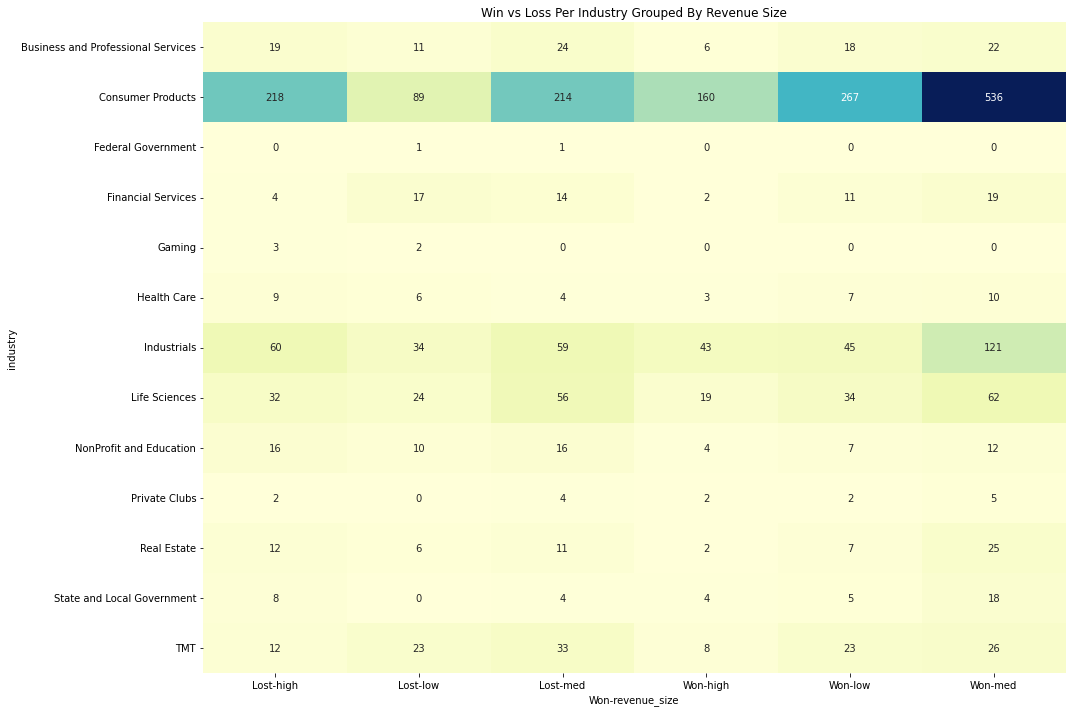

In [23]:
"""Win vs Loss by revenue_size and industry"""
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.crosstab(opp_non_numeric['industry'], [opp_non_numeric['Won'],opp_non_numeric['revenue_size']]),
                        cmap='YlGnBu', cbar=False, annot=True, fmt='g')
plt.title('Win vs Loss Per Industry Grouped By Revenue Size')
plt.tight_layout()

In [24]:
opp_non_numeric.value_counts('Type', normalize=True)

Type
Existing Relationship - New Business    0.524875
Existing Relationship - Renewal         0.246433
New Relationship - New Business         0.228693
dtype: float64

In [25]:
opp_non_numeric.value_counts('Client_Status', normalize=True)

Client_Status
Existing Client    0.720015
New                0.145006
_missing_          0.134979
dtype: float64

The features "Type" and "Client_Status" provide similar infomation about a given opportunity. Type is a more informative and more complete feature. "Client_Status" will be dropped.

In [26]:
"""drop Client_Status"""
opp_non_numeric.drop(columns=['Client_Status'], inplace=True)

In [27]:
opp_non_numeric['Customer_Need'].value_counts()

_missing_                                                               2307
BD                                                                        59
BD Y                                                                      52
Y                                                                         41
ERP                                                                       15
                                                                        ... 
Cloud financials                                                           1
Currently working with Velosio would like to switch partners for F&O       1
support                                                                    1
D365 F&O Support                                                           1
Cross Selling Initiative - Conroy                                          1
Name: Customer_Need, Length: 99, dtype: int64

Printing a count of class membership for the “Customer_Need” column shows this feature details user input in a free text field on opportunity records in Dynamics CRM. The gradient boosting techniques being used for this analysis will not be configured to handle text data. “Customer_Need” will be dropped from the dataset.

In [28]:
opp_non_numeric.drop(columns=['Customer_Need'], inplace=True)

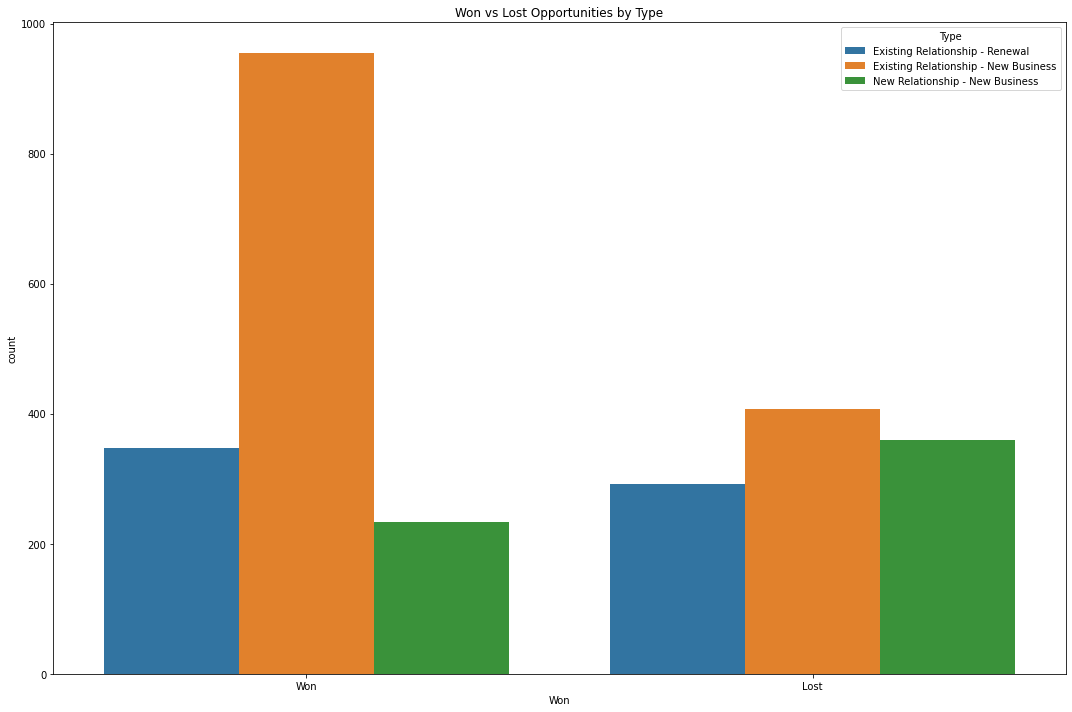

In [29]:
"""plot a count of win/loss by pursuit type"""
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=opp_non_numeric, x='Won', hue='Type')
plt.title('Won vs Lost Opportunities by Type')
plt.tight_layout()

### Methods

- Print Summary Statistics
- Inspect Data Distribution

In [30]:
"""Print summary statistics"""
pd.set_option('display.float_format', lambda x : '%.2f' % x)
opp_numeric.describe()

,Est_Revenue,No_of_Employees,Open_Deals,Open_Revenue,Annual_Revenue,CFY_RSM_Services_Spend,PFY_RSM_Services_Spend,days_active
count,2593.00,2593.00,2593.00,2593.00,2593.00,2593.00,2593.00,2593.00
mean,470459.01,1600.53,0.98,380356.53,427342319.83,494013.46,490259.78,119.83
std,970965.87,5131.94,2.36,1091176.33,1240226338.29,1155883.80,1012485.75,188.14
min,-5659572.00,0.00,0.00,0.00,0.00,-21385.15,-52946.11,0.00
25%,24797.00,100.00,0.00,0.00,24154937.00,0.00,0.00,7.62
50%,100000.00,350.00,0.00,0.00,107879554.00,35101.45,47631.96,43.51
75%,456858.00,1000.00,1.00,59000.00,454811894.00,356172.58,454054.25,147.66
max,14047440.00,95000.00,34.00,7000000.00,30000000000.00,7308498.75,6214816.48,1554.61


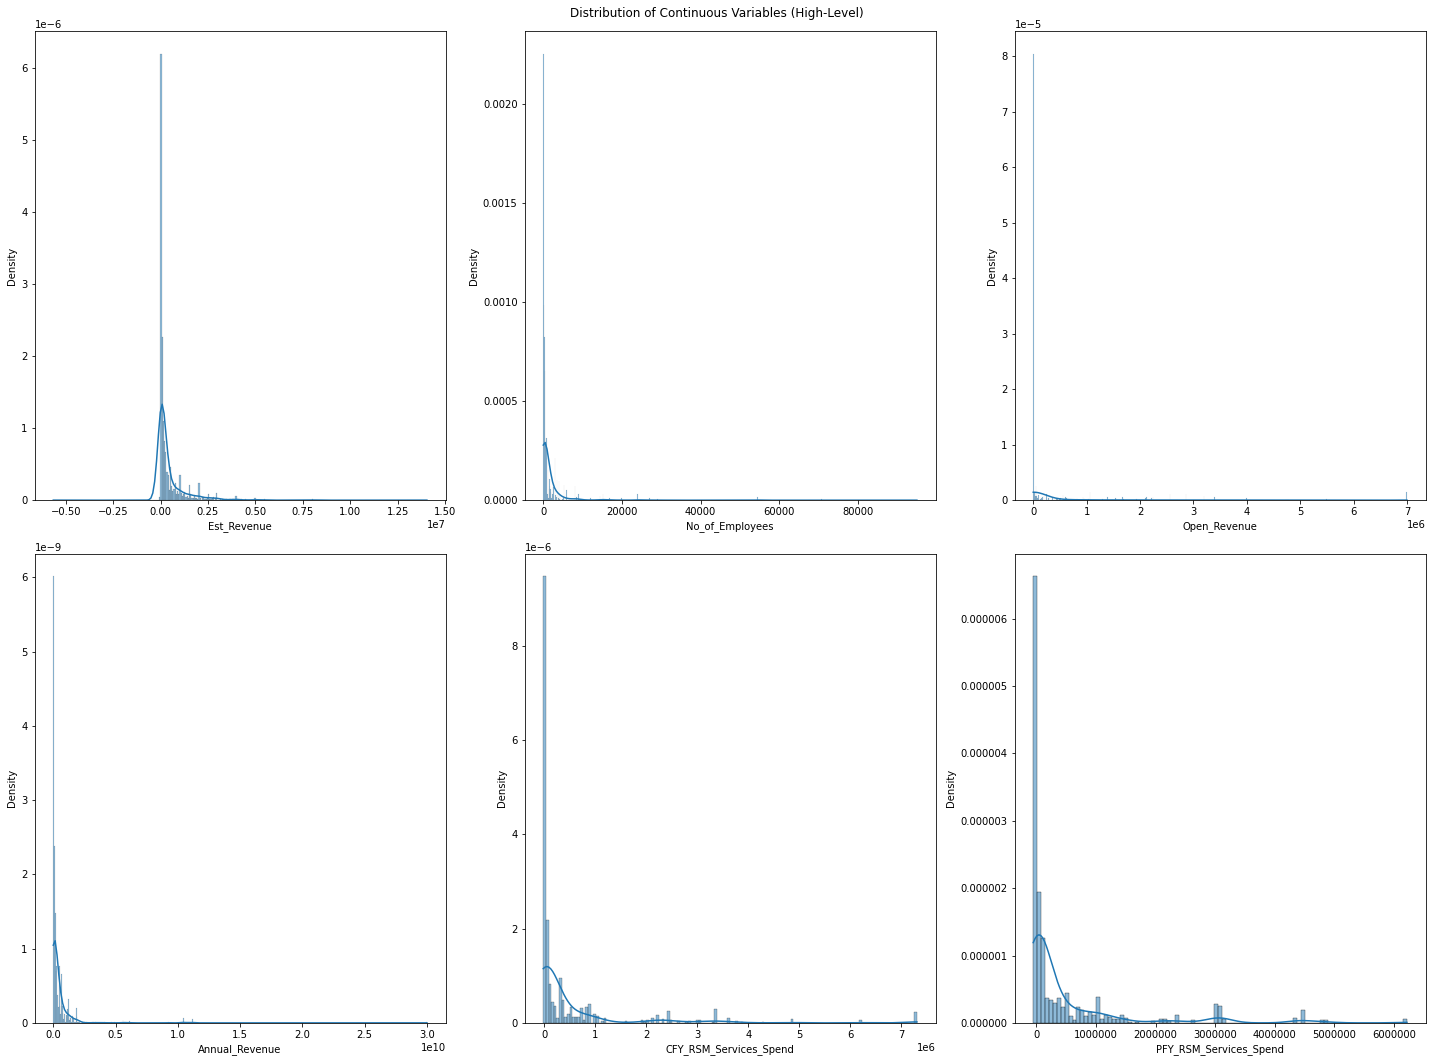

In [31]:
"""plot high-level view of distribution of key continuous predictors"""
fig, ax = plt.subplots(2, 3, figsize=(20, 15))
sns.histplot(opp_numeric, x='Est_Revenue', stat='density', kde=True, ax=ax[0,0])
sns.histplot(opp_numeric, x='No_of_Employees', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(opp_numeric, x='Open_Revenue', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(opp_numeric, x='Annual_Revenue', stat='density', kde=True, ax=ax[1,0])
sns.histplot(opp_numeric, x='CFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(opp_numeric, x='PFY_RSM_Services_Spend', stat='density', kde=True, ax=ax[1, 2])
plt.ticklabel_format(style='Plain')
fig.suptitle('Distribution of Continuous Variables (High-Level)')
plt.tight_layout()

## *Explore Relationship Between Variables*

### Methods

- Pearson's Correlation
- Distribution Plots
- Treemap

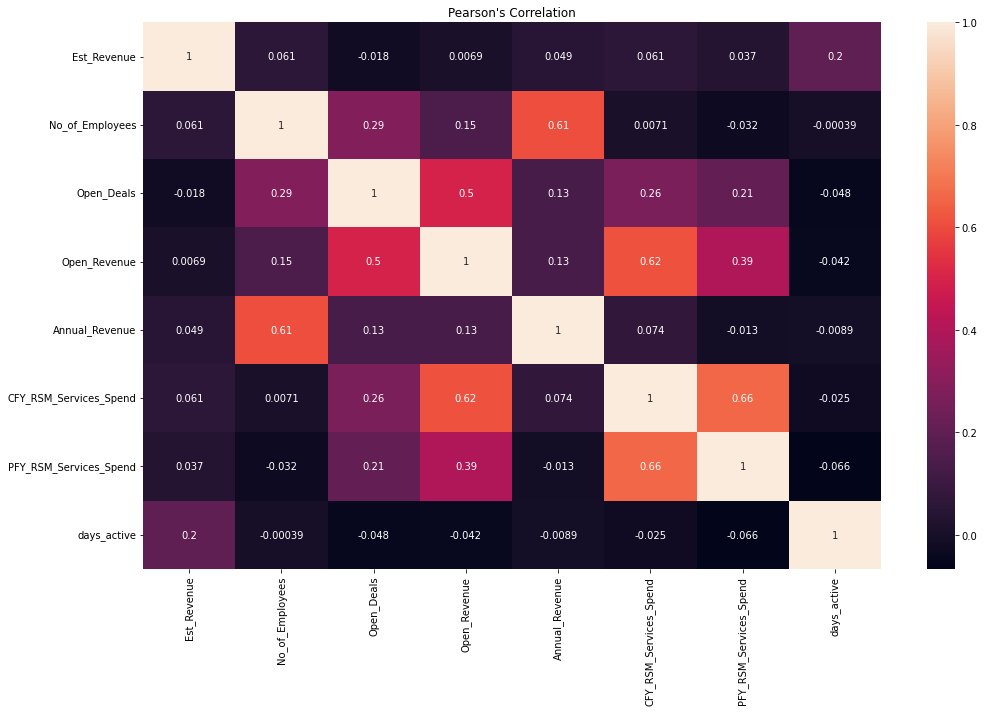

In [32]:
# plot correlation of numeric data
fig, ax = plt.subplots(figsize=(15, 10))
correlation = sns.heatmap(opp_numeric.corr(), cmap='rocket', annot=True)
plt.title('Pearson\'s Correlation')
plt.tight_layout()
plt.show()

In [33]:
"""Transform "Status" to binary outcome and create a treemap to cluster wins by industry and industry_sector"""

opp_non_numeric['Won'] = opp_non_numeric['Won'].apply(lambda x : 1 if (x == 'Won') else 0)
"""create a treemap to cluster wins by industry and industry_sector"""
fig = px.treemap(opp_non_numeric, path=[px.Constant('all'), 'industry', 'industry_sector'], 
                 values = 'Won', title='Wins by Industry Sector')
fig.update_layout(title_x=0.5, margin = dict(t=35, l=25, r=25, b=25))
fig.show()

## *_Feature Selection_*

- Recombine data
- Perform univariate feature selection using Mutual Information Criteria

In [34]:
"""recombine data"""
# join continuous and categorical features on indices
opportunities = pd.merge(opp_numeric, opp_non_numeric, left_index=True, right_index=True, how='inner')
opportunities = pd.merge(opportunities, opp_geographic, left_index=True, right_index=True, how='inner')
# move outcome "Won" to last column idx of dataframe
cols = opportunities.columns.values.tolist()
cols.insert(len(cols), cols.pop(cols.index('Won')))
opportunities = opportunities[cols]

In [35]:
"""preprocessing"""

# drop columns that will not be included in final model
opportunities.drop(columns=['Est_Close_Date', 'System_Close_Date', 'Created_On','Latitude', 
                            'Longitude', 'City', 'County', 'ZIP_Postal_Code' ], inplace=True)
# susbset features for mutual infomation feature selection
x = opportunities.iloc[:, :-1]
y = opportunities.iloc[:, -1]
# index continuous and categorical features
numeric_idx = x.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x.select_dtypes(include=['object', 'bool']).columns
# encode categorical features as integers
oe = OrdinalEncoder()
oe.fit(x[categorical_idx])
# apply robust scaling to continuous features
x[categorical_idx] = oe.transform(x[categorical_idx])
numeric_scaler = RobustScaler()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])


In [36]:
"""define Mutual Info classifier"""

# get indices for categorical features
discrete_idx =[]
for col in categorical_idx:
   discrete_idx.append(x.columns.get_loc(col))
# fit mutual_info_class passing the indices of discrete columns as param
importance = mutual_info_classif(x, y, random_state=14, discrete_features=discrete_idx)
importance = pd.Series(importance, index=x.columns)
importance.sort_values(ascending=False, inplace=True)

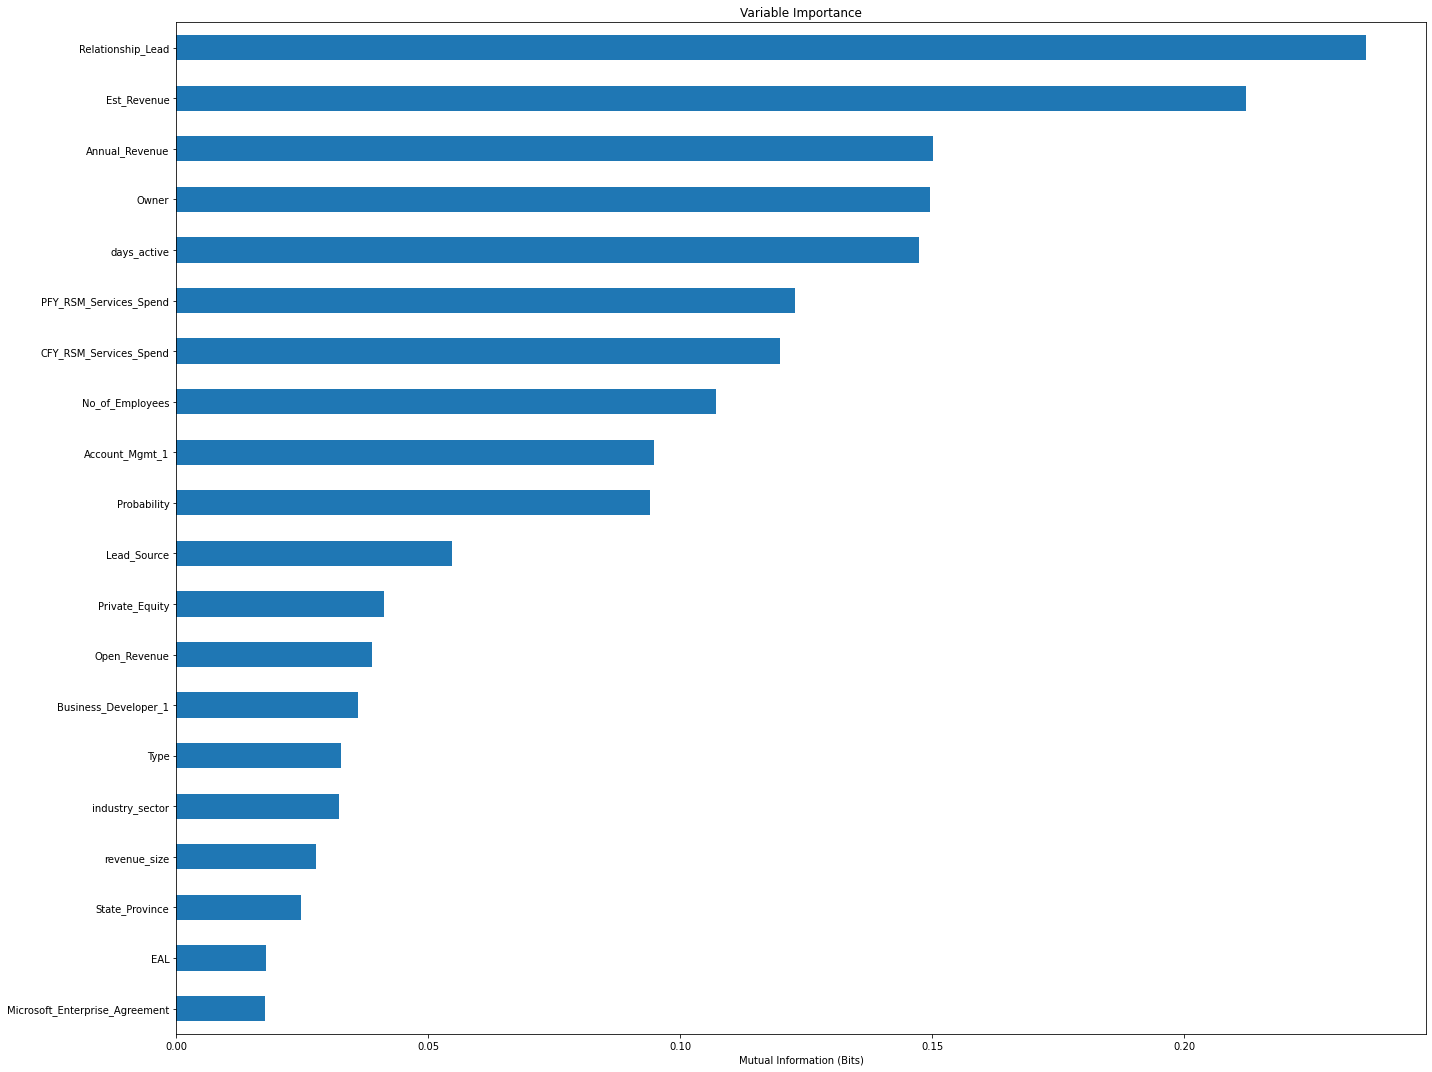

In [37]:
"""Plot variable importance"""

importance[0:20].sort_values(ascending=True).plot.barh(figsize=(20, 15))
plt.title('Variable Importance')
plt.xlabel('Mutual Information (Bits)')
plt.tight_layout()

## *Analytical Methods*

Predicting the outcome of sales opportunities is by no means a new or innovative idea. Organizations with advanced analytics capabilities commonly apply multivariable analysis forecasting methods to their sales data in hopes of increasing revenue. What makes this project unique is the type of analytical method being applied. Analysis will focus on fitting three different flavors of gradient boosting algorithms to the data. Specifically Extreme Gradient Boosted Machine _[(XGBoost)](https://xgboost.readthedocs.io/en/stable/index.html)_, Light Gradient Boosted Machine _[(Light GBM)](https://lightgbm.readthedocs.io/en/latest/)_, and CatBoost _[(CatBoost)](https://catboost.ai/#contacts)_ each with available open-source implementations written in the Python programming language.

## *_Model Selection_*

- Light Gradient Boosted Machine (lgbm)
- Extreme Gradient Boosting (xgboost)
- Catboost

In [38]:
"""preprocessing"""
# subset top 20 features for xgboost
x_onehot = opportunities[importance[0:20].index].copy()
y_onehot = opportunities.iloc[:, -1].copy()
# create index of continuous and categorical features
numeric_idx = x_onehot.select_dtypes(include=['int64', 'float64']).columns
categorical_idx = x_onehot.select_dtypes(include=['object', 'bool']).columns
# apply one hot encoding and robust scaler to xgboost data
x_onehot[categorical_idx] = x_onehot[categorical_idx].astype('category')
x_onehot = pd.get_dummies(x, drop_first=True)
numeric_scaler = RobustScaler()
x_onehot[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])
# subset top 20 features for catboost and lgbm
# catboost and lgbm do not require one-hot encoding of categorical predictors
x = opportunities[importance[0:20].index].copy()
y = opportunities.iloc[:, -1].copy()
x[categorical_idx] = x[categorical_idx].astype('category')
x_categorical_idx = categorical_idx.tolist()
x[numeric_idx] = numeric_scaler.fit_transform(x[numeric_idx])
# lightgbm does not support existence of JSON special characters in feature names
x = x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_onehot_train, x_onehot_test, y_onehot_train, y_onehot_test = train_test_split(x_onehot, 
                                                                y_onehot, test_size=0.30,
                                                                random_state=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y, random_state=14)

In [39]:
y_train.value_counts()

1    1074
0     741
Name: Won, dtype: int64

In [40]:
"""utility function to print classification_report for models"""
def print_report(y_test, predictions):
    target_names = ['Lost', 'Won']
    # sklearn classification report function
    print(classification_report(y_test, predictions, target_names=target_names))

In [41]:
"""utility function to plot feature importance for models"""

def plot_importance(feature_names, feature_importance, model_type, importance_metric):

    #Create a DataFrame of results
    model_results = {'feature_names':feature_names,'feature_importance':feature_importance}
    model_results = pd.DataFrame(model_results)
    # sort results by decreasing feature importance
    model_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    # specify plot size
    plt.figure(figsize=(15,8))
    # create the plot
    sns.barplot(x=model_results['feature_importance'], y=model_results['feature_names'])
    # add labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel(importance_metric)
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [42]:
"""really light gbm"""
# intantiate and fit the model
lgbm_model = LGBMClassifier(objective='binary')
lgbm_model.fit(x_train, y_train, categorical_feature=x_categorical_idx)
# make prediction and print report.
predictions = lgbm_model.predict(x_test)
print_report(y_test, predictions)

              precision    recall  f1-score   support

        Lost       0.84      0.80      0.82       317
         Won       0.87      0.89      0.88       461

    accuracy                           0.85       778
   macro avg       0.85      0.85      0.85       778
weighted avg       0.85      0.85      0.85       778



/Users/benkarabinus/.local/share/virtualenvs/TOOL1_FINAL_PROJECT-_N6x3YZ3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning:

Using categorical_feature in Dataset.



In [46]:
def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            x_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [47]:
"""simple XGBoost"""
# instantiate and fit the model
xgboost_model = XGBClassifier()
xgboost_model.fit(x_onehot_train, y_onehot_train)
# make predictions and print report
predictions = xgboost_model.predict(x_onehot_test)
print_report(y_onehot_test, predictions)

              precision    recall  f1-score   support

        Lost       0.80      0.84      0.82       307
         Won       0.89      0.86      0.88       471

    accuracy                           0.85       778
   macro avg       0.85      0.85      0.85       778
weighted avg       0.86      0.85      0.85       778



In [48]:
"""simple catboost"""
# instantiate the model
catboost_model = CatBoostClassifier(
    custom_loss=[metrics.Accuracy()],
    random_seed=42,
    logging_level='Silent'
)
# fit the model and print report
catboost_model.fit(
    x_train, y_train,
    cat_features=x_categorical_idx,
    eval_set=(x_train, y_train),
     #logging_level='Verbose',  # you can uncomment this for text output
    plot=True
)
predictions = catboost_model.predict(x_test)
print_report(y_test, predictions)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

              precision    recall  f1-score   support

        Lost       0.83      0.78      0.80       317
         Won       0.85      0.89      0.87       461

    accuracy                           0.84       778
   macro avg       0.84      0.83      0.84       778
weighted avg       0.84      0.84      0.84       778



In [ ]:
"""plot feature importance"""
plot_importance(x_test.columns, catboost_model.get_feature_importance(), "Catboost", "Information Gain")

In [ ]:
"""CatBoost hyperparameter tuning"""
# define repeated stratified k-fold cross validation sklearn
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=14)
# define parameter search space as dictionary
search_space = dict()
search_space['learning_rate'] = np.linspace(0, .1, num=50)
search_space['depth'] = np.linspace(1, 10, num=10)
search_space['l2_leaf_reg'] = np.linspace(1, 5, num=5)
search_space['one_hot_max_size'] = np.linspace(1, 20, num=20)
# define CatBoost pool
train_pool = Pool(x_train, y_train, cat_features=x_categorical_idx)
test_pool = Pool(x_test, y_test, cat_features=x_categorical_idx)
catboost_model = CatBoostClassifier(custom_loss=[metrics.Accuracy()], cat_features=x_categorical_idx)
# define randomized search procedure
best_params = catboost_model.randomized_search(search_space, X = x_train, y=y_train, cv=cv,
                                               n_iter = 25, partition_random_seed=14)

In [ ]:
tuned_params = best_params['params']
tuned_params

In [ ]:
tuned_catboost_model = CatBoostClassifier(**tuned_params,
                                          logging_level='Silent',random_seed=14,
                                          iterations=1000, custom_loss=[metrics.Accuracy()])
tuned_catboost_model.fit(X=x_train, y=y_train, cat_features=x_categorical_idx)
predictions = tuned_catboost_model.predict(x_test)
print_report(y_test, predictions)

In [ ]:
catboost_model.get_all_params()

In [ ]:
plot_importance(x_test.columns, tuned_catboost_model.get_feature_importance(), "Catboost", "Information Gain")

In [ ]:
y_train.value_counts()